In [2]:
# MNIST dataset downloaded from Kaggle :
#https://www.kaggle.com/c/digit-recognizer/data

#подключение библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split

#вывод изображения
def img_plot(img):
  plt.figure(figsize=(7,7))

  grid_data = img.values.reshape(28,28)
  plt.imshow(grid_data,interpolation= "none" , cmap="gray")
  plt.show()

In [3]:
#чтение данных
base = ''
data_with_labels = pd.read_csv(base + 'train.csv')

In [4]:
data_with_labels

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Все функции

# # # # # # # # # # # # # # # # # # # # # # # #
# перевод в полярные координаты
def convert_to_polar(row):
  x = row.iloc[0]
  y = row.iloc[1]
  r = np.sqrt(x**2 + y**2)
  if r == 0:
    phi = 0
  elif x>0 and y>=0:
    phi = np.arctan(y/x)
  elif x>0 and y<0:
    phi = np.arctan(y/x) + 2*np.pi
  elif x<0:
    phi =  np.arctan(y/x) + np.pi
  elif y>0:
    phi = np.pi / 2
  elif y<0:
    phi = 3*np.pi / 2
  row[row.index[0]] = phi
  row[row.index[1]] = r
  return row

def polar_conversion(state, target, data_train, data_train_means):
  list_of_labels = data_train[target].unique()
  list_of_labels.sort()
  #данные в виде списка, где каждый элемент это датафрейм содержащий лишь данные с определенной меткой
  data = []
  for labels in list_of_labels:
    data.append(data_train.loc[data_train[target] == labels])
  #для каждого класса
  polar_data = []
  for idx in range(len(data)):
    #текущая метка
    current_label = data[idx][target].unique()[0]
    print(current_label)
    #данные без метки
    data_unlabeled = data[idx].drop(columns=[target])
    #средние у данных с текущей меткой по всем координатам
    means = data_train_means.loc[current_label]
    #сдвигаем на средние по каждой координате
    biased = data_unlabeled - means
    #проходим по всем парам координат и переводим в полярные координаты
    polar = pd.DataFrame()
    for j in range(int(biased.shape[1] / 2)):
      t = biased.iloc[:, [2*j, 2*j+1]].apply(convert_to_polar, axis='columns')
      polar = pd.concat([polar, t], axis = 1)
    polar_data.append(polar)
  return polar_data
# # # # # # # # # # # # # # # # # # # # # # # #

# # # # # # # # # # # # # # # # # # # # # # # #
# построение кусочно постоянной функции
def func_def(state, target, data_train, polar_data, D):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    #число делений отрезка 0; 2pi
    Dlist = [2*np.pi * j /D for j in range(D+1)]
    dim = polar_data[0].shape[1]
    #для каждой метки строим функцию и раскладываем ее в ряд фурье
    labeled_func = []
    for i in range(len(list_of_labels)):
        piece_wise_func = []
        for p in range(int(dim/2)):
            func_dim = []
            #максимумы на отрезках
            for j in range(D):     
                func_dim.append(polar_data[i].iloc[:, [2*p, 2*p+1]].loc[(polar_data[i].iloc[:, 2*p] >= Dlist[j]) & (polar_data[i].iloc[:, 2*p] <= Dlist[j+1])].max())
            
            #вычисление функции на отрезках, где нет ни одной точки
            temp = func_dim.copy()
            #присваиваем четным координатам соответствующие значения на отрезке от 0 до 2 пи
            for j in range(D):
                temp[j].iloc[0] = 2*np.pi * j /D
            #причем новые "восстановленные данные" НЕ участвуют в восстановлении последующих
            for j in range(D):
                if np.isnan(func_dim[j].iloc[1]):
                    k=1
                    while k<=D:
                        left = (j-k+D)%D
                        right = (k+j)%D
                        if not np.isnan(func_dim[left].iloc[1]) and not np.isnan(func_dim[right].iloc[1]):
                            ar_mean = (func_dim[left].iloc[1] + func_dim[right].iloc[1]) / 2
                            temp[j].iloc[1] = ar_mean
                            break
                        elif not np.isnan(func_dim[left].iloc[1]):
                            ar_mean = func_dim[left].iloc[1]
                            temp[j].iloc[1] = ar_mean
                            break
                        elif not np.isnan(func_dim[right].iloc[1]):
                            ar_mean = func_dim[right].iloc[1]
                            temp[j].iloc[1] = ar_mean
                            break
                        else:
                            k+=1
            piece_wise_func.append(temp)
        labeled_func.append(piece_wise_func)
    return labeled_func
# # # # # # # # # # # # # # # # # # # # # # # #

# # # # # # # # # # # # # # # # # # # # # # # #
# вычисление коэффициентов ряда фурье
def fourier_coef_calc(state, target, data_train, labeled_piece_func, D, M):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    dim = int((data_train.shape[1] - 1) / 2)
    row_labels = [0]
    for idx in range (1, M):
        row_labels.append(idx)
        row_labels.append(-idx)
    #для каждой метки
    labeled_coef = []
    for i in range(len(list_of_labels)):
        #для каждой пары координат от 0 до 392
        dim_coef = []
        for p in range(int(dim)):
            coef = pd.DataFrame(complex(0), index = row_labels, columns = ['value'])
            for idx in row_labels:
                sum = complex(0)
                #если коэффициент с индексом 0
                if idx == 0:
                    for j in range(D):
                        g = labeled_piece_func[i][p][j].iloc[1]
                        sum += g
                    sum /= D
                #если коэффициент с ненулевым индексом
                else:
                    for j in range(D):
                        g = labeled_piece_func[i][p][j].iloc[1]
                        a = 2*np.pi * j /D
                        b = 2*np.pi * (j + 1) /D
                        left_number = complex( np.cos(-b* idx), np.sin(-b* idx))
                        right_number = complex( np.cos(-a* idx), np.sin(-a* idx))
                        denominator = complex(imag = - idx)
                        sum += g* (left_number - right_number) / denominator
                    sum /= 2*np.pi
                coef.loc[idx] = sum
            dim_coef.append(coef)
        labeled_coef.append(dim_coef)
    return labeled_coef
# # # # # # # # # # # # # # # # # # # # # # # #

# # # # # # # # # # # # # # # # # # # # # # # #
# классификация
def get_label(state, target, data_train, data_train_means, fourier_coef, image):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    dim = int((data_train.shape[1] - 1) / 2)
    votes = [0 for i in range (len(list_of_labels))]
    for i in range(len(list_of_labels)):
        current_label = list_of_labels[i]
        temp = image.drop(columns=[target])
        #сдвигаем на среднее
        means = data_train_means.loc[current_label]
        biased = temp - means
        polar = pd.DataFrame()
        for j in range(int(biased.shape[1] / 2)):
          t = biased.iloc[:, [2*j, 2*j+1]].apply(convert_to_polar, axis='columns')
          polar = pd.concat([polar, t], axis = 1)
        for j in range(int(polar.shape[1] / 2)):
            vals = polar.iloc[0, 2*j:2*j+2]
            phi = vals.iloc[0]
            r = vals.iloc[1]
            coefs = fourier_coef[i][j].copy()
            fourier_value = complex(0)
            indexes = coefs.index
            for idx in indexes:
                exp_num = complex(np.cos(idx * phi), np.sin(idx*phi))
                fourier_value += exp_num * coefs.loc[idx].iloc[0]
            real_v = fourier_value.real
            if r <= real_v:
                votes[i]+=1
    return max(range(len(votes)), key = lambda x: votes[x])
# # # # # # # # # # # # # # # # # # # # # # # #

In [8]:
# перевод в полярные координаты
def convert_to_polar(row):
  x = row.iloc[0]
  y = row.iloc[1]
  r = np.sqrt(x**2 + y**2)
  if r == 0:
    phi = 0
  elif x>0 and y>=0:
    phi = np.arctan(y/x)
  elif x>0 and y<0:
    phi = np.arctan(y/x) + 2*np.pi
  elif x<0:
    phi =  np.arctan(y/x) + np.pi
  elif y>0:
    phi = np.pi / 2
  elif y<0:
    phi = 3*np.pi / 2
  row[row.index[0]] = phi
  row[row.index[1]] = r
  return row

def polar_conversion(state, target, data_train, data_train_means):
  list_of_labels = data_train[target].unique()
  list_of_labels.sort()
  #данные в виде списка, где каждый элемент это датафрейм содержащий лишь данные с определенной меткой
  data = []
  for labels in list_of_labels:
    data.append(data_train.loc[data_train[target] == labels])
  #для каждого класса
  polar_data = []
  for idx in range(len(data)):
    #текущая метка
    current_label = data[idx][target].unique()[0]
    print(current_label)
    #данные без метки
    data_unlabeled = data[idx].drop(columns=[target])
    #средние у данных с текущей меткой по всем координатам
    means = data_train_means.loc[current_label]
    #сдвигаем на средние по каждой координате
    biased = data_unlabeled - means
    #проходим по всем парам координат и переводим в полярные координаты
    polar = pd.DataFrame()
    for j in range(int(biased.shape[1] / 2)):
      t = biased.iloc[:, [2*j, 2*j+1]].apply(convert_to_polar, axis='columns')
      polar = pd.concat([polar, t], axis = 1)
    polar_data.append(polar)
  return polar_data

target = 'label'
state = 148

#разбиваем данные на тренировочные и тестовые
data_train, data_test = train_test_split(
    data_with_labels, stratify=data_with_labels[target], test_size=0.33, random_state=state)
#средние по всем координатам, для всех таргетов
data_train_means = data_train.groupby(target).mean()

polar_data = polar_conversion(state, target, data_train, data_train_means)

# data_train_means

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.331299,0.626653,0.378772,0.108511,0.093591,0.019668,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [20]:
# сохраним данные в полярных координатах
for i in range (10):
    polar_data[i].to_csv("polar_converted_" + str(i) + ".csv")

In [ ]:
# чтение данных в полярных координатах
polar_data = []
for i in range (10):
    polar_data.append(pd.read_csv("polar_converted_" + str(i) + ".csv"))

In [41]:
# построение кусочно постоянной функции
def func_def(state, target, data_train, polar_data, D):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    #число делений отрезка 0; 2pi
    Dlist = [2*np.pi * j /D for j in range(D+1)]
    dim = polar_data[0].shape[1]
    #для каждой метки строим функцию и раскладываем ее в ряд фурье
    labeled_func = []
    for i in range(len(list_of_labels)):
        piece_wise_func = []
        for p in range(int(dim/2)):
            func_dim = []
            #максимумы на отрезках
            for j in range(D):     
                func_dim.append(polar_data[i].iloc[:, [2*p, 2*p+1]].loc[(polar_data[i].iloc[:, 2*p] >= Dlist[j]) & (polar_data[i].iloc[:, 2*p] <= Dlist[j+1])].max())
            
            #вычисление функции на отрезках, где нет ни одной точки
            temp = func_dim.copy()
            #присваиваем четным координатам соответствующие значения на отрезке от 0 до 2 пи
            for j in range(D):
                temp[j].iloc[0] = 2*np.pi * j /D
            #причем новые "восстановленные данные" НЕ участвуют в восстановлении последующих
            for j in range(D):
                if np.isnan(func_dim[j].iloc[1]):
                    k=1
                    while k<=D:
                        left = (j-k+D)%D
                        right = (k+j)%D
                        if not np.isnan(func_dim[left].iloc[1]) and not np.isnan(func_dim[right].iloc[1]):
                            ar_mean = (func_dim[left].iloc[1] + func_dim[right].iloc[1]) / 2
                            temp[j].iloc[1] = ar_mean
                            break
                        elif not np.isnan(func_dim[left].iloc[1]):
                            ar_mean = func_dim[left].iloc[1]
                            temp[j].iloc[1] = ar_mean
                            break
                        elif not np.isnan(func_dim[right].iloc[1]):
                            ar_mean = func_dim[right].iloc[1]
                            temp[j].iloc[1] = ar_mean
                            break
                        else:
                            k+=1
            piece_wise_func.append(temp)
        labeled_func.append(piece_wise_func)
    return labeled_func

target = 'label'
state = 1488
D = 10
#результат в виде списка result[метка][индексы от 0 до 392][разбиение по полярному углу]
labeled_piece_func = func_def(state, target, data_train, polar_data, D)

In [5]:
# label = 0
# indexz = 100
# sss = 0
# for i in range(D):
#     print(labeled_piece_func[label][indexz][i])

In [44]:
# вычисление коэффициентов ряда фурье
def fourier_coef_calc(state, target, data_train, labeled_piece_func, D, M):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    dim = int((data_train.shape[1] - 1) / 2)
    row_labels = [0]
    for idx in range (1, M):
        row_labels.append(idx)
        row_labels.append(-idx)
    #для каждой метки
    labeled_coef = []
    for i in range(len(list_of_labels)):
        #для каждой пары координат от 0 до 392
        dim_coef = []
        for p in range(int(dim)):
            coef = pd.DataFrame(complex(0), index = row_labels, columns = ['value'])
            for idx in row_labels:
                sum = complex(0)
                #если коэффициент с индексом 0
                if idx == 0:
                    for j in range(D):
                        g = labeled_piece_func[i][p][j].iloc[1]
                        sum += g
                    sum /= D
                #если коэффициент с ненулевым индексом
                else:
                    for j in range(D):
                        g = labeled_piece_func[i][p][j].iloc[1]
                        a = 2*np.pi * j /D
                        b = 2*np.pi * (j + 1) /D
                        left_number = complex( np.cos(-b* idx), np.sin(-b* idx))
                        right_number = complex( np.cos(-a* idx), np.sin(-a* idx))
                        denominator = complex(imag = - idx)
                        sum += g* (left_number - right_number) / denominator
                    sum /= 2*np.pi
                coef.loc[idx] = sum
            dim_coef.append(coef)
        labeled_coef.append(dim_coef)
    return labeled_coef
M = 3
fourier_coef = fourier_coef_calc(state, target, data_train, labeled_piece_func, D, M)

1


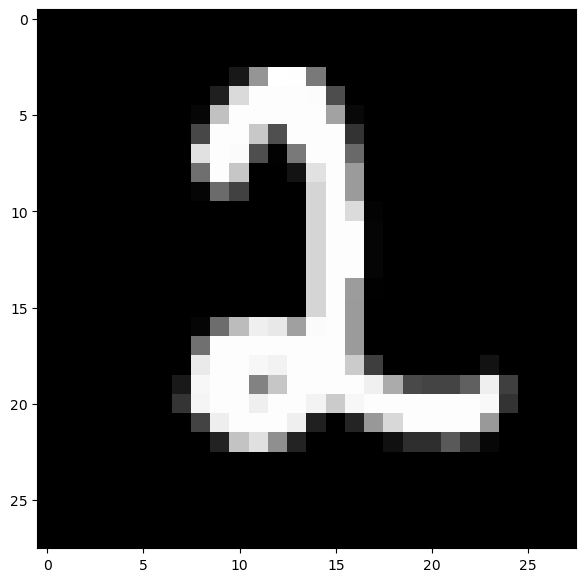

In [55]:
# классификация
def get_label(state, target, data_train, data_train_means, fourier_coef, image):
    list_of_labels = data_train[target].unique()
    list_of_labels.sort()
    dim = int((data_train.shape[1] - 1) / 2)
    votes = [0 for i in range (len(list_of_labels))]
    for i in range(len(list_of_labels)):
        current_label = list_of_labels[i]
        temp = image.drop(columns=[target])
        #сдвигаем на среднее
        means = data_train_means.loc[current_label]
        biased = temp - means
        polar = pd.DataFrame()
        for j in range(int(biased.shape[1] / 2)):
          t = biased.iloc[:, [2*j, 2*j+1]].apply(convert_to_polar, axis='columns')
          polar = pd.concat([polar, t], axis = 1)
        for j in range(int(polar.shape[1] / 2)):
            vals = polar.iloc[0, 2*j:2*j+2]
            phi = vals.iloc[0]
            r = vals.iloc[1]
            coefs = fourier_coef[i][j].copy()
            fourier_value = complex(0)
            indexes = coefs.index
            for idx in indexes:
                exp_num = complex(np.cos(idx * phi), np.sin(idx*phi))
                fourier_value += exp_num * coefs.loc[idx].iloc[0]
            real_v = fourier_value.real
            if r <= real_v:
                votes[i]+=1
    return max(range(len(votes)), key = lambda x: votes[x])
#нули 25 38 44 57 
#пять 69
indexzxc = 0
label_test = get_label(state, target, data_train, data_train_means, fourier_coef, data_test.iloc[indexzxc:indexzxc+1])
print(label_test)
# data_test.describe()
img_plot(data_test.iloc[indexzxc:indexzxc+1].drop(columns=[target]))

In [56]:
# тестирование

# правильно предсказанные
#  true_positive = [0 for i in range(10)]
# неправильно предсказанные т.е. число предсказанных меток, не являющиеся верными
#  false_positive = [0 for i in range(10)]
# не предсказанные, т.е. число меток, которые были неверно предсказаны
#  negative = [0 for i in range(10)]
 # p_number = 0
 # count =  0
 # true_positive = [0 for i in range(10)]
 # false_positive = [0 for i in range(10)]
 # negative = [0 for i in range(10)]

p_number = 0
count =  0
true_positive = [0 for i in range(10)]
false_positive = [0 for i in range(10)]
negative = [0 for i in range(10)]


for i in range(p_number, data_test.shape[0]):
    image = data_test.iloc[i:i+1]
    real_label = image.label.iloc[0]
    label = get_label(state, target, data_train, data_train_means, fourier_coef, image)
    if label == 1:
        count_one +=1
    if label !=1:
        print('not one')
        
        print('not one', file=open('log.txt','a'))
    if real_label == label:
        count+=1
        print('AAAAAA')
        print('indeed, label is ', label)
        true_positive[label] += 1
        
        print('AAAAAA', file=open('log.txt','a'))
        print('indeed, label is ', label, file=open('log.txt','a'))    
    else:
        false_positive[label] += 1
        negative[real_label] += 1
    print('pic number ', i+1)
    print('count = ', count)
    print('true_positive = ', true_positive)
    print('false_positive = ', false_positive)
    print('negative = ', negative)

    print('pic number ', i+1, file=open('log.txt','a'))
    print('count = ', count, file=open('log.txt','a'))
    print('true_positive = ', true_positive, file=open('log.txt','a'))
    print('false_positive = ', false_positive, file=open('log.txt','a'))
    print('negative = ', negative, file=open('log.txt','a'))

file.close()

AAAAAA
indeed, label is  1
pic number  201
count =  29
true_positive =  [1, 20, 0, 0, 0, 0, 1, 7, 0, 0]
false_positive =  [0, 145, 0, 6, 4, 0, 0, 16, 0, 1]
negative =  [22, 0, 30, 22, 16, 19, 19, 15, 14, 15]
pic number  202
count =  29
true_positive =  [1, 20, 0, 0, 0, 0, 1, 7, 0, 0]
false_positive =  [0, 146, 0, 6, 4, 0, 0, 16, 0, 1]
negative =  [22, 0, 30, 22, 16, 19, 19, 15, 15, 15]
not one
pic number  203
count =  29
true_positive =  [1, 20, 0, 0, 0, 0, 1, 7, 0, 0]
false_positive =  [0, 146, 0, 6, 4, 0, 0, 17, 0, 1]
negative =  [23, 0, 30, 22, 16, 19, 19, 15, 15, 15]
not one
AAAAAA
indeed, label is  6
pic number  204
count =  30
true_positive =  [1, 20, 0, 0, 0, 0, 2, 7, 0, 0]
false_positive =  [0, 146, 0, 6, 4, 0, 0, 17, 0, 1]
negative =  [23, 0, 30, 22, 16, 19, 19, 15, 15, 15]
pic number  205
count =  30
true_positive =  [1, 20, 0, 0, 0, 0, 2, 7, 0, 0]
false_positive =  [0, 147, 0, 6, 4, 0, 0, 17, 0, 1]
negative =  [23, 0, 30, 22, 16, 19, 19, 16, 15, 15]
AAAAAA
indeed, label is  


KeyboardInterrupt

